# Kernel Testing Notebook

The purpose of this notebook is to compare the effectiveness of each GPR kernel on the dataset.

We've concluded that the RBF kernel is sufficient, although others are also good.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, RationalQuadratic, ExpSineSquared, DotProduct, Matern, WhiteKernel
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler


LHS_url = 'https://raw.githubusercontent.com/benkim1226/footballdata/master/LHS_complete.csv'
LHS_data = pd.read_csv(LHS_url, index_col = 0)
LHS_data = LHS_data.reset_index()

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_LHS = scaler.fit_transform(LHS_data)
scaled_LHS = pd.DataFrame(scaled_LHS)

# Graphing

Comparing training and testing MAE for various kernels

In [ ]:
import random
sample_sizes = np.arange(10,300,10)

mae_train = []
mae_test = []

for s in sample_sizes:
  """
  This function iterates through a tuple of sample_sizes to see MAE differences.
  """
  indexes = random.sample(range(0, 1000), s)
  sample_data = scaled_LHS.loc[indexes] # use scaled data
  X = sample_data.loc[:,0:13]

  y = list(sample_data.loc[:,14])

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  kernel = RationalQuadratic(length_scale=1.0, alpha=1.0, length_scale_bounds=(1e-05, 1e5), alpha_bounds=(1e-05, 100000.0))

  # kernel = ExpSineSquared(length_scale=1.0, periodicity=1.0, length_scale_bounds=(1e-05, 100000.0), periodicity_bounds=(1e-05, 100000.0))

  # kernel = DotProduct(sigma_0=1.0, sigma_0_bounds=(1e-05, 100000.0))

  # kernel = Matern(length_scale=1.0, length_scale_bounds=(1e-05, 100000.0), nu=1.5)

  gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, normalize_y= True)

  gpr.fit(X_train, y_train)

  y_train_pred = gpr.predict(X_train)
  y_test_pred = gpr.predict(X_test)

  mae_train.append(mean_absolute_error(y_train, y_train_pred))
  mae_test.append(mean_absolute_error(y_test, y_test_pred))

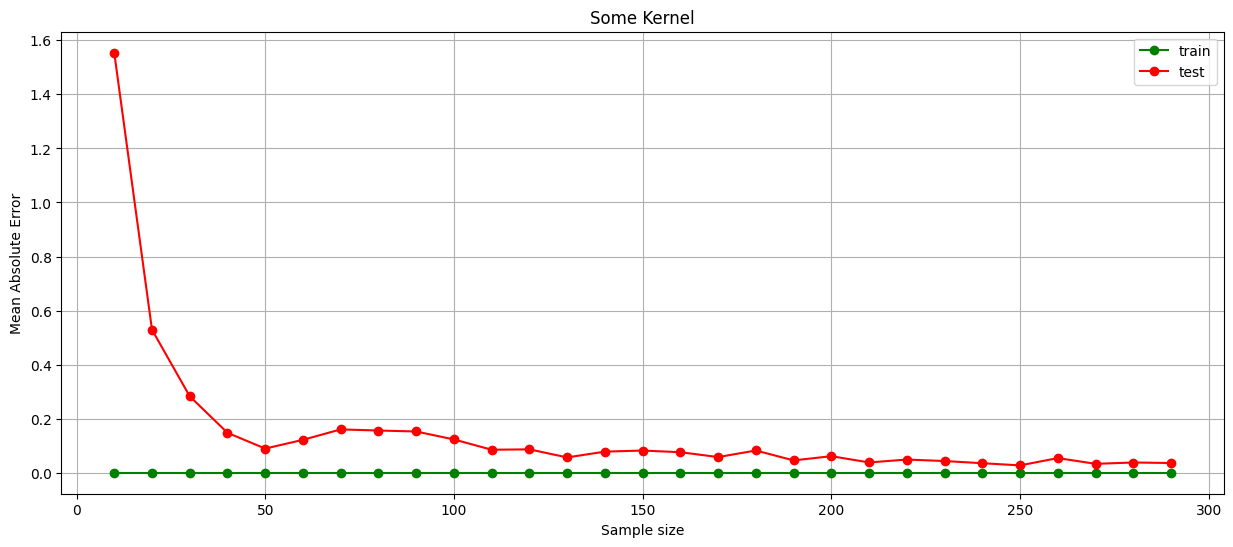

In [10]:
plt.figure(figsize=(15,6))
plt.plot(sample_sizes, mae_train, 'o-', color='green', label='train')
plt.plot(sample_sizes, mae_test, 'o-', color='red', label='test')
plt.legend()
plt.grid()
plt.xlabel('Sample size')
plt.ylabel('Mean Absolute Error')
plt.title('Some Kernel')
plt.show()

Let us rewrite the function to include each kernel in the same graph

In [20]:
kernels = ['Constant','DP','RQ','Matern','RBF','White']

In [ ]:
import random

sample_sizes = list(np.around((np.logspace(1, 2.5, 10)),0))
sample_sizes = [int(x) for x in sample_sizes]

mae_test_constant = []
mae_test_RQ = []
mae_test_DP = []
mae_test_matern = []
mae_test_RBF = []
mae_test_white = []

for s in sample_sizes:

  """
  This loop iterates through a tuple of sample_sizes to see MAE differences.
  """

  indexes = random.sample(range(0, 1000), s)
  sample_data = scaled_LHS.loc[indexes]

  X = sample_data.loc[:,0:13]
  y = sample_data.loc[:,14]


  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  print(X_train.head())
  print(y_train.head())

  for i in kernels:
    if i == 'Constant':
      kernel = ConstantKernel(constant_value= 1)
      gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, alpha = 0.1)
      gpr.fit(X_train, y_train)
      y_test_pred = gpr.predict(X_test)
      mae_test_constant.append(mean_absolute_error(y_test, y_test_pred))

    elif i == 'RQ':
      length_scale_array = np.array([1]*len(X.columns))
      kernel = RationalQuadratic(length_scale= 1.0, alpha=1.0, length_scale_bounds=(1e-4, 1e4), alpha_bounds=(1e-4, 1e4))
      gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, alpha = 0.1)
      gpr.fit(X_train, y_train)
      y_test_pred = gpr.predict(X_test)
      mae_test_RQ.append(mean_absolute_error(y_test, y_test_pred))

    elif i == 'DP':
      kernel = DotProduct(sigma_0=1.0, sigma_0_bounds=(1e-4, 1e4))
      gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, alpha = 0.1)
      gpr.fit(X_train, y_train)
      y_test_pred = gpr.predict(X_test)
      mae_test_DP.append(mean_absolute_error(y_test, y_test_pred))

    elif i == 'Matern':
      length_scale_array = np.array([1]*len(X.columns))
      kernel = Matern(length_scale=length_scale_array, length_scale_bounds=(1e-4, 1e4), nu=1.5)
      gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, alpha = 0.1)
      gpr.fit(X_train, y_train)
      y_test_pred = gpr.predict(X_test)
      mae_test_matern.append(mean_absolute_error(y_test, y_test_pred))

    elif i == 'RBF':
      length_scale_array = np.array([1]*len(X.columns))
      kernel = 1 * RBF(length_scale=length_scale_array, length_scale_bounds=(1e-4, 1e4))
      gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, alpha = 0.1)
      gpr.fit(X_train, y_train)
      y_test_pred = gpr.predict(X_test)
      mae_test_RBF.append(mean_absolute_error(y_test, y_test_pred))

    else: # some null hypothesis, in this instance, RBF with a WhiteKernel
      length_scale_array = np.array([1]*len(X.columns))
      kernel = 1 * RBF(length_scale=length_scale_array, length_scale_bounds=(1e-4, 1e4)) + WhiteKernel(noise_level = 100)
      gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, alpha = 0.1)
      gpr.fit(X_train, y_train)
      y_test_pred = gpr.predict(X_test)
      mae_test_white.append(mean_absolute_error(y_test, y_test_pred))


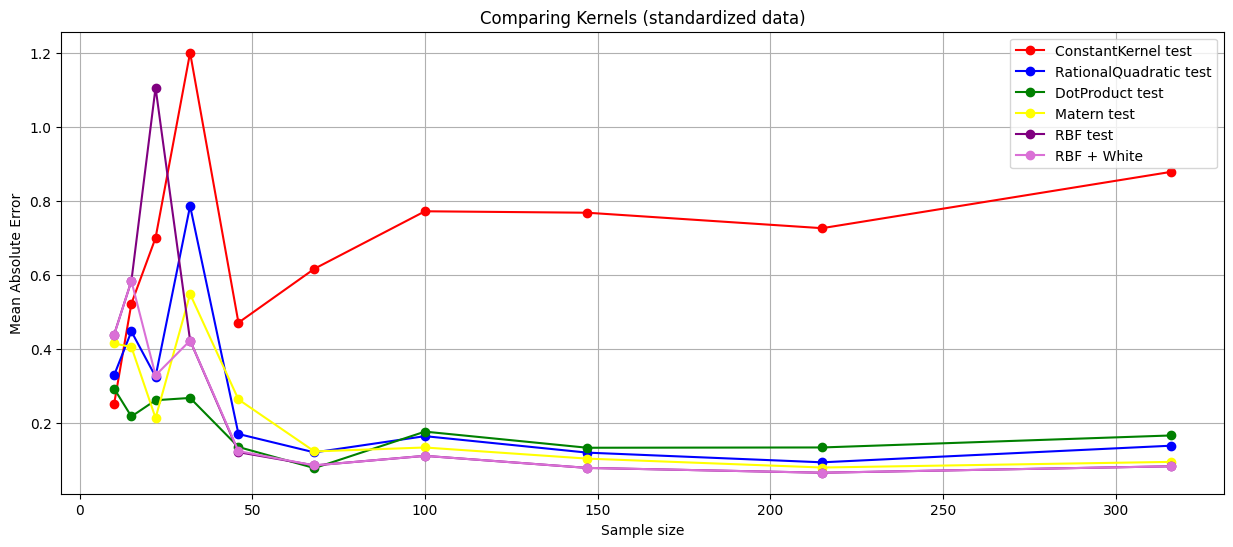

In [23]:
plt.figure(figsize=(15,6))
plt.plot(sample_sizes, mae_test_constant, 'o-', color='red', label='ConstantKernel test')
plt.plot(sample_sizes, mae_test_RQ, 'o-', color='blue', label='RationalQuadratic test')
plt.plot(sample_sizes, mae_test_DP, 'o-', color='green', label='DotProduct test')
plt.plot(sample_sizes, mae_test_matern, 'o-', color='yellow', label='Matern test')
plt.plot(sample_sizes, mae_test_RBF, 'o-', color='purple', label='RBF test')
plt.plot(sample_sizes, mae_test_white, 'o-', color='orchid', label='RBF + White')

plt.legend()
plt.grid()
plt.xlabel('Sample size')
plt.ylabel('Mean Absolute Error')
plt.title('Comparing Kernels (standardized data)')
plt.show()